# Face recognition using a Siamese network with fastai

In this post I explore a simple face recognition system using a Siamese network. It is based on the following fastai material
- [https://docs.fast.ai/tutorial.siamese.html](https://docs.fast.ai/tutorial.siamese.html) 
- [https://github.com/fastai/fastbook/blob/master/11_midlevel_data.ipynb](https://github.com/fastai/fastbook/blob/master/11_midlevel_data.ipynb) 
- [https://github.com/fastai/fastbook/blob/master/15_arch_details.ipynb](https://github.com/fastai/fastbook/blob/master/15_arch_details.ipynb)

What makes a Siamese network attractive is you don't need a ton of data. It works by learning whether two images are similiar or not, rather than learn an explicit class label. As a demonstration I'll be using the [Yale Face Database](http://vision.ucsd.edu/content/yale-face-database). This is an ancient dataset from 1997 that consists of 15 individuals. There are 11 images per individual, each image has a different facial expression or lighting. Each image is a 320x243 grayscale GIF. In total there are 165 images. A dataset this size is laughably too small for a typical image classification network. But with a Siamese network we're comparing pairs of images. With 165 images this allows for 165x165 = 27225 unique training pairs. This is a much more reasonable dataset size! 

To recognize a new image I take a simple approach and compare it against all existing images and accumulate the similarity and see which one has the highest score.

This Jupyter notebook can be downloaded here https://github.com/nghiaho12/fastai_projects/blob/main/tale_face_siamese.ipynb 

1. [Load the Yale Face dataset](#load_yale)
2. [Set up custom transform and model](#setup_model)
3. [Set up DataLoader](#setup_data)
4. [Train the model](#train_model)
5. [Evaluate on test set](#eval_test)
6. [Some thoughts](#some_thoughts)

# 1. Load the Yale Face dataset<a name="load_yale"></a>
The dataaset has a simple filename structure with the exception of a redundant file and an incorrectly named file.

In [1]:
from fastai.vision.all import *
import os

if torch.cuda.is_available() == False:
    raise ValueError("No CUDA device found!")
    
#plt.style.use('dark_background')

path = untar_data("http://vision.ucsd.edu/datasets/yale_face_dataset_original/yalefaces.zip")

# redundant file
if os.path.exists(path/"subject01.glasses.gif"):
    os.remove(path/"subject01.glasses.gif") 
    
# incorrect naming    
if os.path.exists(path/"subject01.gif"):
    os.rename(path/"subject01.gif", path/"subject01.centerlight")

files = L(path.glob("subject*"))

# 2. Set up custom transform and model<a name="setup_model"></a>
This is mostly copy and paste from the fastai tutorials. I make a slight change to the model by using a simpler head after the encoder. It takes the two encoded vectors and performs an absolute difference, which then gets fed into a fully connected layer. This felt a bit more intuitive than using the resnet18 head.

In [6]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs):
        img1, img2, same = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1, t2 = tensor(img1), tensor(img2)
            t1, t2 = t1.permute(2,0,1), t2.permute(2,0,1)
        else: t1, t2 = img1, img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1, line, t2], dim=2), title=same, ctx=ctx)
    
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()        
        self.lbl2files = {l : L(f for f in files if label_func(f) == l) for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2, t = self.valid.get(f, self._draw(f)) # calls draw() if key=f does not exist
        img1, img2 = PILImage.create(f), PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same:
            cls = random.choice(L(l for l in self.labels if l != cls))
        return random.choice(self.lbl2files[cls]), same
              
class SiameseModel(Module):
    def __init__(self, encoder):
        self.encoder = encoder
        self.fc = nn.Linear(1024, 1)
        
    def similarity(self, e1, e2):
        x = torch.abs(e1 - e2)
        x = self.fc(x)
        x = nn.Sigmoid()(x)
        return x
    
    def forward(self, x1, x2):
        e1 = self.encoder(x1)
        e2 = self.encoder(x2)
        return self.similarity(e1, e2)
    
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 2)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): SiameseImage(x[0][i], x[1][i], ['Not similar','Similar'][x[2][i].item()]).show(ctx=ctx)    

# 3. Set up DataLoader<a name="setup_data"></a>
This again is mostly copy and paste from the fastai tutorials. For the test set I decided to make it interesting by using only faces with glasses. I wanted to see if the network can work on face type it has never seen before.

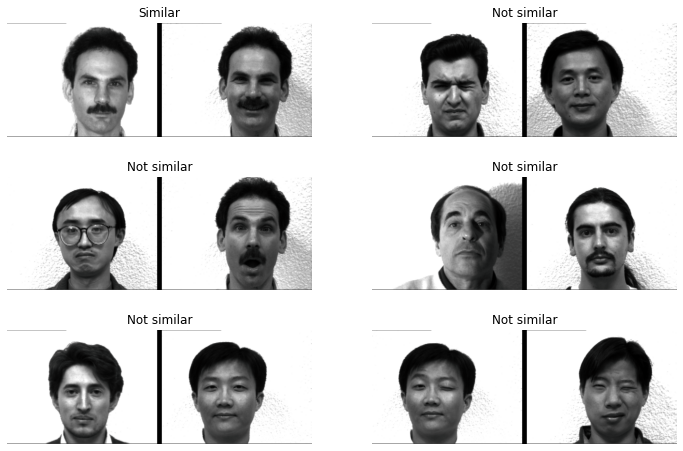

In [7]:
def label_func(fname):
    return re.match(r'^subject(.*)\.', fname.name).groups()[0]

train_files = L()
test_files = L()

for f in files:
    if ".glasses" in f.name:
        test_files.append(f)
    else:
        train_files.append(f)
            
splits = RandomSplitter()(train_files)
tfm = SiameseTransform(train_files, label_func, splits)
tls = TfmdLists(train_files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[ToTensor], after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], bs=16)

# sanity check
dls.show_batch()

# 4. Train the model<a name="train_model"></a>
I'm using resnet18 as the base model. There was a bit of of gotcha I came across when coding this up. Previously, I didn't call torch.squeeze. This caused a mismatch in tensor dimensions, but due to broadcasting it ran without errors. The results that came out were wrong though. So always check your dimensions!

The training epoch is set to 150 to make sure we sample enough of all the possible image pairs.

In [8]:
def my_loss(out, target):
    return nn.BCELoss()(torch.squeeze(out, 1), target.float())

def my_accuracy(input, target):
    label = input > 0.5
    return (label.squeeze(1) == target).float().mean()

encoder = nn.Sequential(
    create_body(resnet18, cut=-2),
    AdaptiveConcatPool2d(),
    nn.Flatten()
)

model = SiameseModel(encoder)

epoch,train_loss,valid_loss,my_accuracy,time
0,0.771358,0.798573,0.433333,00:04
1,0.762180,0.764269,0.633333,00:03
2,0.707662,0.418891,0.766667,00:03
3,0.690268,0.467284,0.866667,00:03
4,0.663904,0.192052,0.933333,00:03
5,0.631431,0.603939,0.666667,00:03
6,0.592009,0.485361,0.733333,00:03
7,0.559610,0.353569,0.866667,00:03
8,0.537616,0.321258,0.866667,00:03
9,0.515465,0.305035,0.866667,00:03


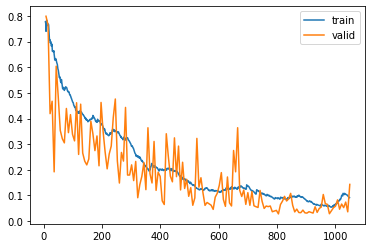

In [9]:
learn = Learner(dls, model, loss_func=my_loss, metrics=my_accuracy).to_fp16()
#learn.lr_find()
learn.fit(150)
learn.save("yale_face")
learn.recorder.plot_loss()

The validation loss is rather bumpy because we're using a very small fixed set of image pairs. 20% of training images by default.

# 5. Evaluate on test set<a name="eval_test"></a>
For each test image I compare it against all the training images. Each training image will vote using the similarity score from the network. The scores are then averaged out and the best one is picked as the label. I'm doing this in a very slow loop to keep things simple. In practice you would cache the encoded training image vectors and run the prediction in batches to speed things up.

I had issues with my laptop's GPU running out of memory when doing this loop. The solution is to turn off gradient  calculation when doing inference using torch.no_grad in a context manager.

subject01.glasses most similar to label (01, 0.9998)
subject02.glasses most similar to label (02, 0.9999)
subject03.glasses most similar to label (03, 0.9996)
subject04.glasses most similar to label (04, 0.9995)
subject05.glasses most similar to label (05, 0.9993)
subject06.glasses most similar to label (06, 0.9998)
subject07.glasses most similar to label (07, 0.9998)
subject08.glasses most similar to label (08, 0.9998)
subject09.glasses most similar to label (09, 0.9960)
subject10.glasses most similar to label (10, 0.9816)
subject11.glasses most similar to label (11, 0.9997)
subject12.glasses most similar to label (12, 0.9994)
subject13.glasses most similar to label (13, 1.0000)
subject14.glasses most similar to label (14, 0.9988)
subject15.glasses most similar to label (15, 0.9999)

correct matches 15/15


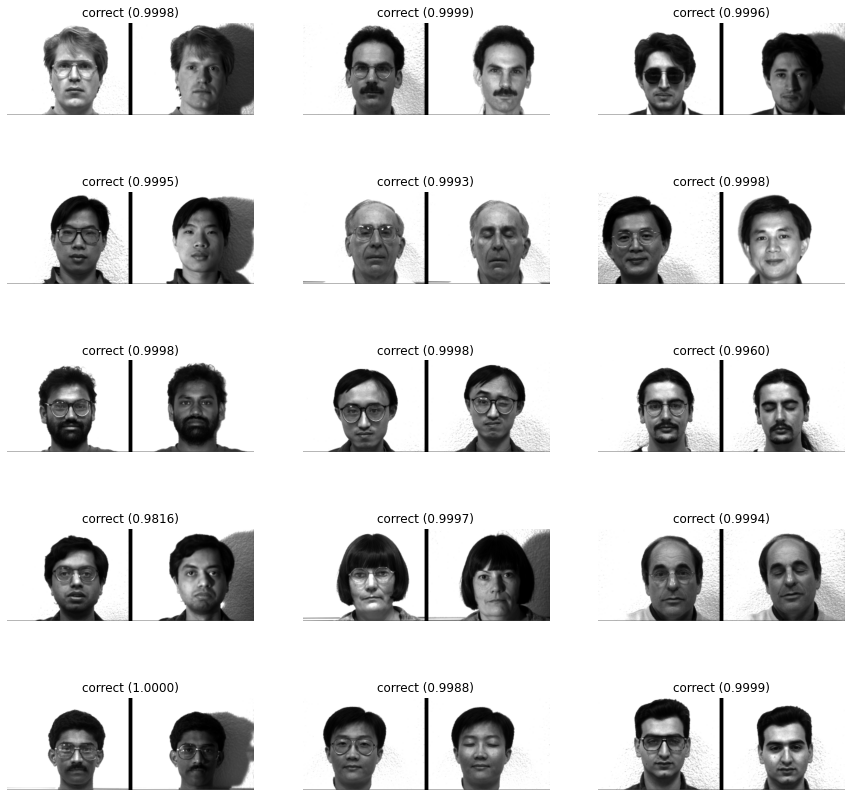

In [12]:
learn = Learner(dls, model, loss_func=my_loss, metrics=my_accuracy).to_fp16()
learn.load("yale_face")
learn.model.cuda()

correct = 0

pipe = Pipeline([IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)])

# cache the encoded training iamges
encoded = torch.zeros(len(train_files), learn.model.fc.in_features).cuda()

for idx, f in enumerate(train_files):
    img = PILImage.create(f)

    # disable gradients to save GPU memory!
    with torch.no_grad(): 
        x = pipe(ToTensor()(img).cuda())
        x = learn.model.encoder(x)
        encoded[idx, :] = x
        
fig, axs = plt.subplots(5, 3, figsize=(15,15))

for f, ax in zip(sorted(test_files), axs.flat):
    img = PILImage.create(f)
    
    # find the best match
    # disable gradients to save GPU memory!
    
    tally = {}
    
    with torch.no_grad(): 
        x = pipe(ToTensor()(img).cuda())
        x = learn.model.encoder(x)
        
        # this will use tensor broadcast
        y = learn.model.similarity(encoded, x)
                
        best_idx = torch.argmax(y)
        best_score = y[best_idx][0].item()        
        best_label = label_func(train_files[best_idx])
        best_img = PILImage.create(train_files[best_idx])
        
    if label_func(f) == best_label:
        correct += 1
        SiameseImage(img, best_img, f"correct ({best_score:.4f})").show(ctx=ax)
    else:
        SiameseImage(img, best_img, "incorrect").show(ctx=ax)
    
    print(f"{f.name} most similar to label ({best_label}, {best_score:.4f})")
    
print("")
print(f"correct matches {correct}/{len(test_files)}")

It managed to correctly classified all the testing images. It turns out the dataset isn't very consistent about people wearing glasses or not. So the network learnt some faces with glasses. Still pretty cool results though!

# Some thoughts<a name="some_thoughts"></a>
I've shown how to create a simple face recognition system using a Siamese network with very little training data. Some things to try out are different distance metric between the encoded vectors. PyTorch has a torch.nn.CosineSimilarity class that looks interesting.